In [222]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from arch.unitroot import engle_granger

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()
from hurst import compute_Hc

import warnings
warnings.filterwarnings('ignore')


In [223]:
def stationarity_test(X, cutoff=0.05):
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    # trends = ['n', 'c', 'ct', 'ctt']
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = engle_granger(S1, S2)
            test_statistic = result.stat
            pvalue = result.pvalue
            score_matrix[i, j] = test_statistic
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs, pvalue

def halflife_(z_array):
    z_lag = np.roll(z_array,1)
    z_lag[0] = 0
    z_ret = z_array - z_lag
    z_ret[0] = 0

    #adds intercept terms to X variable for regression
    z_lag2 = sm.add_constant(z_lag)

    model = sm.OLS(z_ret,z_lag2)
    res = model.fit()

    halflife = -np.log(2) / res.params[1]
    return halflife

## Get crypto data

In [224]:
from pathlib import Path

ROOT = Path('data/crypto')

In [225]:
def convert_unix_to_date(df: pd.DataFrame) -> pd.Series:
    date = df['Date'].copy()
    date.loc[df['tradecount'].isna()] = pd.to_datetime(df.loc[df['tradecount'].isna(), 'Unix'], unit='s')
    # date.
    date = pd.to_datetime(date)  # оставшаяся часть данных была в формате строки
    return date

btc_usdt_file = ROOT / 'Binance_BTCUSDT_1h.csv'
eth_usdt_file = ROOT / 'Binance_ETHUSDT_1h.csv'
bnb_usdt_file = ROOT / 'Binance_BNBUSDT_1h.csv'

link_usdt_file = ROOT / 'Binance_LINKUSDT_1h.csv'
ltc_usdt_file = ROOT / 'Binance_LTCUSDT_1h.csv'
neo_usdt_file = ROOT / 'Binance_NEOUSDT_1h.csv'

qtum_usdt_file = ROOT / 'Binance_QTUMUSDT_1h.csv'

df_btc = pd.read_csv(btc_usdt_file, skiprows=1)
df_eth = pd.read_csv(eth_usdt_file, skiprows=1)
df_bnb = pd.read_csv(bnb_usdt_file, skiprows=1)

df_link = pd.read_csv(link_usdt_file, skiprows=1)
df_ltc = pd.read_csv(ltc_usdt_file, skiprows=1)
df_neo = pd.read_csv(neo_usdt_file, skiprows=1)

df_qtum = pd.read_csv(qtum_usdt_file, skiprows=1)

In [226]:
df_btc['Date'] = df_btc['Date'].apply(lambda x: str(x).split('.')[0])
df_eth['Date'] = df_eth['Date'].apply(lambda x: str(x).split('.')[0])
df_bnb['Date'] = df_bnb['Date'].apply(lambda x: str(x).split('.')[0])
df_link['Date'] = df_link['Date'].apply(lambda x: str(x).split('.')[0])
df_ltc['Date'] = df_ltc['Date'].apply(lambda x: str(x).split('.')[0])
df_neo['Date'] = df_neo['Date'].apply(lambda x: str(x).split('.')[0])
df_qtum['Date'] = df_qtum['Date'].apply(lambda x: str(x).split('.')[0])

In [227]:
df_btc['Date'] = convert_unix_to_date(df_btc)
df_eth['Date'] = convert_unix_to_date(df_eth)
df_bnb['Date'] = convert_unix_to_date(df_bnb)

df_link['Date'] = convert_unix_to_date(df_link)
df_ltc['Date'] = convert_unix_to_date(df_ltc)
df_neo['Date'] = convert_unix_to_date(df_neo)

df_qtum['Date'] = convert_unix_to_date(df_qtum)

In [228]:
dataframes = {'btc': df_btc, 'eth': df_eth, 'bnb': df_bnb, 
              'link': df_link, 'ltc': df_ltc, 'neo': df_neo, 'qtum': df_qtum,} 

from functools import reduce

for suffix, df in dataframes.items():
    df.columns = [f'{col}_{suffix}' if col != 'Date' else col for col in df.columns]

merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dataframes.values())

In [229]:
merged_df.drop_duplicates(inplace=True)
df = merged_df.sort_values(by='Date')
df = df.set_index('Date')
df.dropna(inplace=True)

In [230]:
columns_to_keep = [col for col in df.columns if col.startswith('Close_')]
df = df[columns_to_keep]

Before performing cointegration test split data into training and test

In [231]:
start = '2022-07-01'
end = '2023-06-01'
train = df.loc[:start]
validation = df.loc[start:end]
test = df.loc[end:]

In [232]:
scores, pvalues, pairs, pvalue = find_cointegrated_pairs(train)
print(pvalues)

[[1.00000000e+00 5.29946721e-01 4.10326372e-01 1.35712844e-01
  2.90787123e-01 3.68830754e-01 2.97280994e-02]
 [1.00000000e+00 1.00000000e+00 7.16252127e-02 7.63543770e-01
  6.70557220e-01 6.52577402e-01 2.35049760e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 6.06556997e-01
  6.31766098e-01 6.31770202e-01 6.83543626e-03]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  9.66187413e-02 2.15361009e-02 1.58418259e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 3.64581906e-03 5.90068374e-04]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.86105820e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00]]


In [233]:
pairs

[('Close_bnb', 'Close_qtum'),
 ('Close_ltc', 'Close_neo'),
 ('Close_ltc', 'Close_qtum')]

In [234]:
pvalue = 1
pair = ('','')
for pair in pairs:
    _, _, _, pvalue_pair = find_cointegrated_pairs(train[[pair[0], pair[1]]])
    if pvalue > pvalue_pair:
        pvalue = pvalue_pair
        pair = (pair[0], pair[1])

In [235]:
pairs = [pair]

In [236]:
x_col = [x[0] for x in pairs]
y_col = [y[1] for y in pairs]

x_col_log = [f'{x}_log' for x in x_col]
y_col_log = [f'{y}_log' for y in y_col]

df_filtered = df[list(set(x_col + y_col))]

In [237]:
cols = list(set(x_col + y_col))

for col in cols:
    df_filtered[f'{col}_log'] = np.log(df_filtered[col])

In [238]:
df = df_filtered

## Split data

In [239]:
start = '2022-07-01'
end = '2023-06-01'
train = df.loc[:start]
validation = df.loc[start:end]
test = df.loc[end:]

In [240]:
train.shape, validation.shape, test.shape

((30244, 4), (8063, 4), (4223, 4))

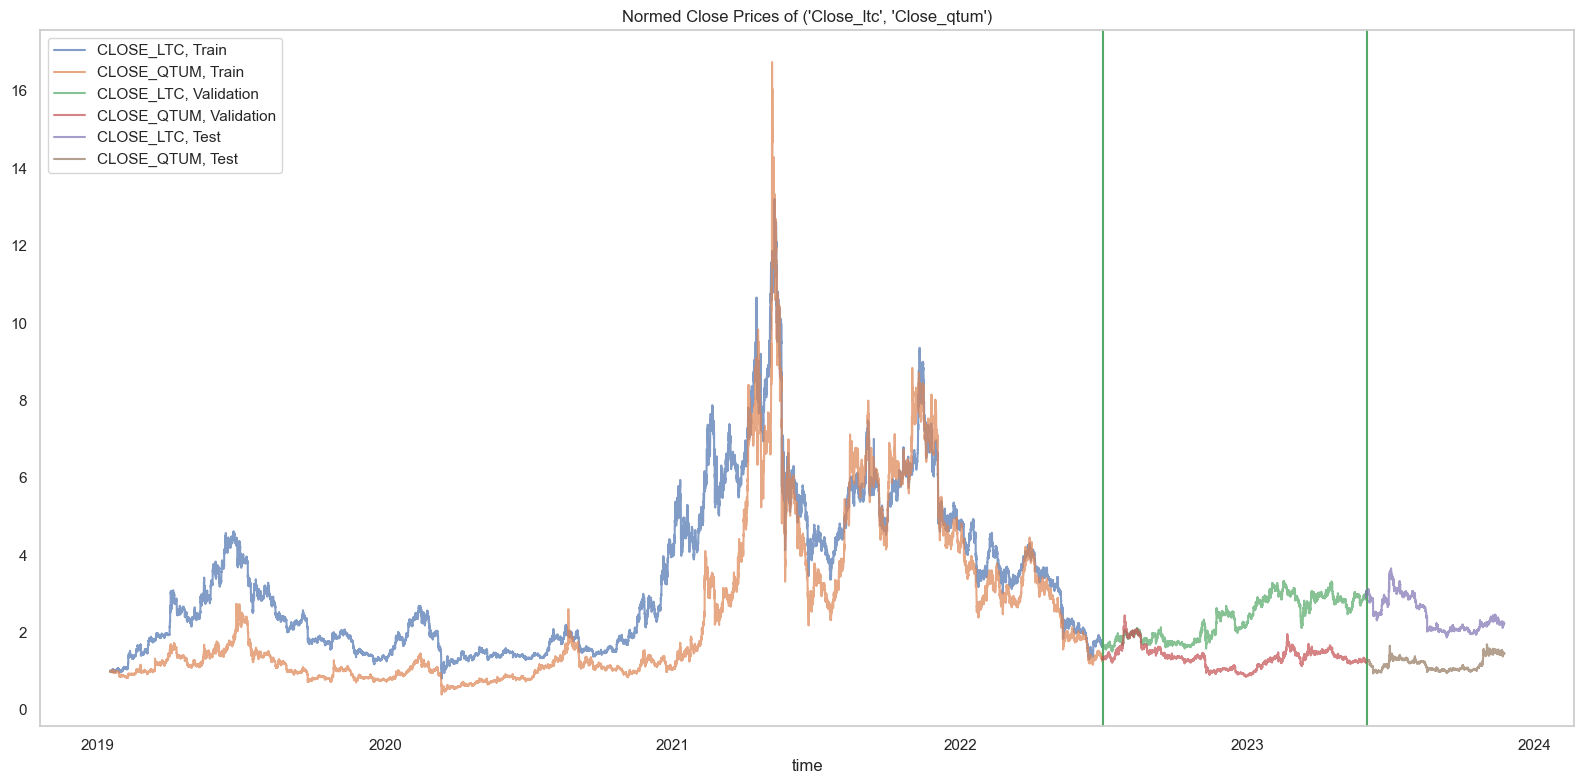

In [241]:
# n_rows = 2
# n_cols = 3

n_rows = 1
n_cols = 1

plt.figure(figsize=(16, 8))

for i, pair in enumerate(pairs):
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(train[f'{pair[0]}'] / train[f'{pair[0]}'].iloc[0], alpha=0.7, label=f'{pair[0].upper()}, Train')
    plt.plot(train[f'{pair[1]}'] / train[f'{pair[1]}'].iloc[0], alpha=0.7, label=f'{pair[1].upper()}, Train')
    plt.axvline(train.index[-1], color='C2')

    plt.plot(validation[f'{pair[0]}'] / train[f'{pair[0]}'].iloc[0], alpha=0.7, label=f'{pair[0].upper()}, Validation')
    plt.plot(validation[f'{pair[1]}'] / train[f'{pair[1]}'].iloc[0], alpha=0.7, label=f'{pair[1].upper()}, Validation')
    plt.axvline(validation.index[-1], color='C2')

    plt.plot(test[f'{pair[0]}'] / train[f'{pair[0]}'].iloc[0], alpha=0.7, label=f'{pair[0].upper()}, Test')
    plt.plot(test[f'{pair[1]}'] / train[f'{pair[1]}'].iloc[0], alpha=0.7, label=f'{pair[1].upper()}, Test')

    plt.grid()
    plt.legend()
    plt.title(f'Normed Close Prices of {pair}')
    plt.xlabel('time')

plt.tight_layout()
plt.show()

## Fitting regression

In [242]:
import seaborn as sns
import glob
from tqdm.auto import tqdm
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from arch.unitroot import engle_granger
from statsmodels.tsa.stattools import adfuller, kpss

In [243]:
def add_trend(n_obs, start_value, order):
    trend = np.arange(start_value, start_value + n_obs) ** order
    trend = trend.reshape(-1, 1)
    return trend

def add_const(n_obs):
    const = np.ones((n_obs, 1))
    return const

def find_best_params(X, Y, trends):
    result = []
    for trend in trends:
        eg_test = engle_granger(Y, X, trend=trend)
        output = [eg_test._pvalue, eg_test.cointegrating_vector, trend, eg_test]
        result.append(output)
    best_result = np.argmin([i[0] for i in result])
    return result[best_result]

In [244]:
from collections import defaultdict
import math

def fit_regressions(data: pd.DataFrame, train_size: int, test_size: int, x_col_log: str, y_col_log: str) -> dict:
    """
    window size: train_size + test_size
    shift: test_size
    """
    result = defaultdict(list)
    trends = ['n', 'c', 'ct', 'ctt']
    train_size_days = 24 * train_size
    test_size_days = round(24 * test_size)

    n_folds = math.floor((data.shape[0] - train_size_days) / test_size_days)

    for i in tqdm(range(n_folds)):
        train_start = test_size_days * i
        test_start = train_start + train_size_days
        test_end = test_start + test_size_days

        train_df = data.iloc[train_start:test_start]
        test_df = data.iloc[test_start:test_end]
        x = train_df[x_col_log].copy().reset_index(drop=True)
        y = train_df[y_col_log].copy().reset_index(drop=True)
        
        p_value, coef_vector, trend, tester = find_best_params(x, y, trends)

        test = test_df[[x_col_log, y_col_log]].copy()

        test['const'] = add_const(test.shape[0])
        test['trend'] = add_trend(test.shape[0], 0, 1)
        test['quadratic_trend'] = add_trend(test.shape[0], 0, 2)

        beta = coef_vector.get(x_col_log, 0)
        intercept = coef_vector.get('const', 0)
        trend_coef = coef_vector.get('trend', 0)
        quadratic_trend_coef = coef_vector.get('quadratic_trend', 0)


        preds = intercept + beta * test[x_col_log] + trend_coef * test['trend'] + quadratic_trend_coef * test['quadratic_trend']
        spread = test[y_col_log].copy() + preds
        indexes = test.index

        result['dates'].append([train_start, test_start, test_end])
        result['coefs'].append(coef_vector)
        result['p_values'].append(p_value)
        result['preds'].extend(preds)
        result['indexes'].extend(indexes)
        result['spread'].extend(spread)
    return result

In [245]:
def regresions_for_pairs(data: pd.DataFrame, train_size: int, test_size: int, pairs: list):
    dictionaries = []
    for pair in pairs:
        result = fit_regressions(data[[pair[0], pair[1], f'{pair[0]}_log', f'{pair[1]}_log']], train_size, test_size, f'{pair[0]}_log', f'{pair[1]}_log')
        dictionaries.append(result)
    return dictionaries

## Train

In [246]:
train_days = 2
test_days = 1

result = regresions_for_pairs(train, train_days, test_days, pairs)

  0%|          | 0/1258 [00:00<?, ?it/s]

In [247]:
spread = []
for res in result:
    spread_ = pd.Series(np.array(res['spread']), index=np.array(res['indexes']), name='spread')
    spread.append(spread_)

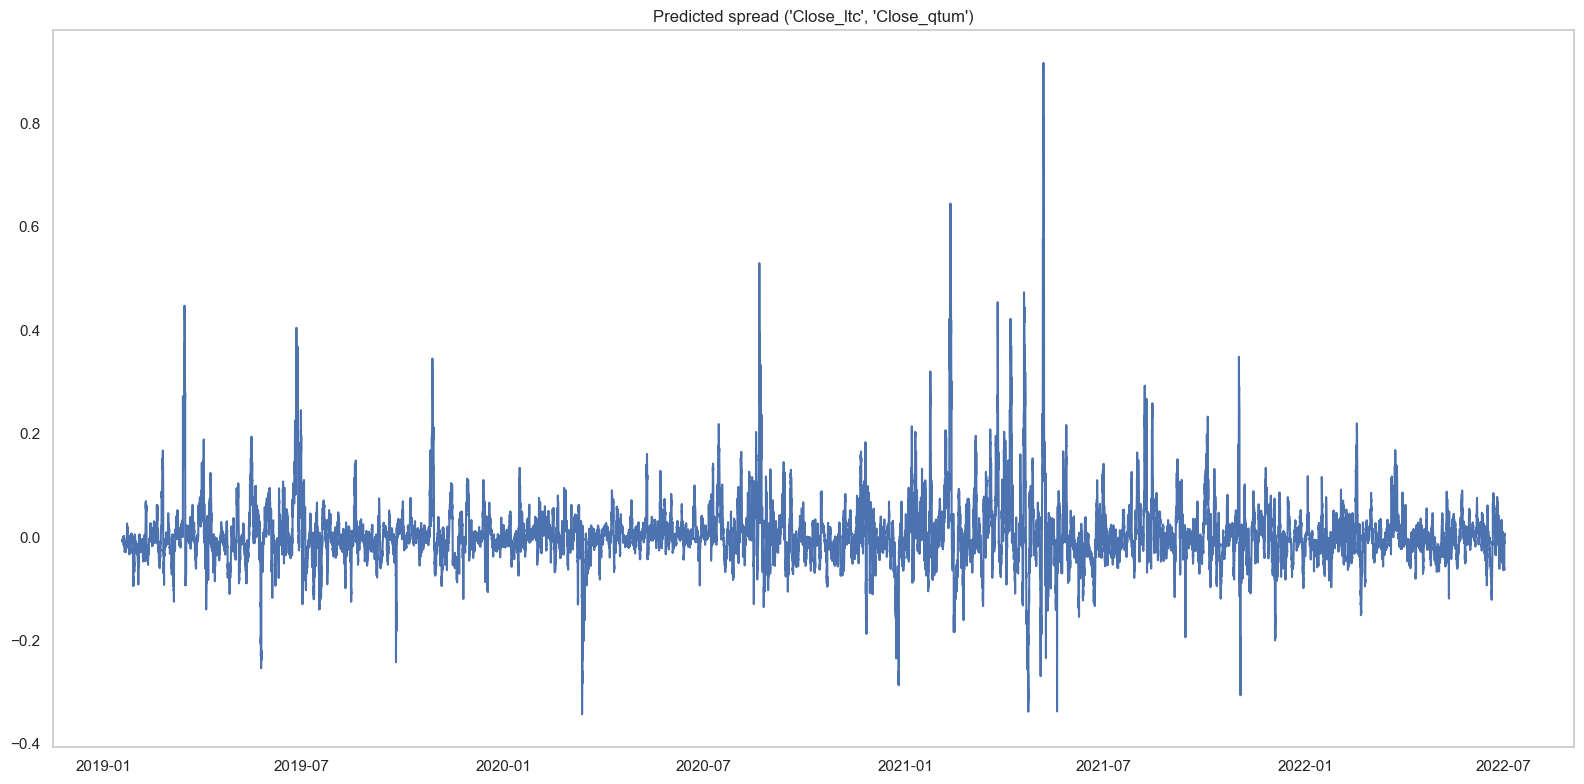

In [248]:
n_rows = 1
n_cols = 1

plt.figure(figsize=(16, 8))

for i, (spread_, pair) in enumerate(zip(spread, pairs)):
    plt.subplot(n_rows, n_cols, i+1)

    plt.plot(spread_)
    plt.grid()
    plt.title(f'Predicted spread {pair[0], pair[1]}')

plt.tight_layout()
plt.show()

In [249]:
# пfor all data set
train_days = 2
test_days = 1

fit_results = regresions_for_pairs(df.iloc[train.shape[0] - 24 * train_days:], train_days, test_days, pairs)

  0%|          | 0/509 [00:00<?, ?it/s]

In [250]:
spread = []
for res in fit_results:
    spread_ = pd.Series(np.array(res['spread']), index=np.array(res['indexes']), name='spread')
    spread.append(spread_)

In [251]:
prices = df
for pair, spread_ in zip(pairs, spread): 
    prices = prices.merge(spread_, how='left', left_index=True, right_index=True)
    prices = prices[~prices.index.to_series().duplicated()]
    prices.rename(columns={'spread': f'spread_{pair[0]}_and_{pair[1]}'}, inplace=True)

In [252]:
train = prices.loc[:'2022-07-01 00:00:00']
validation = prices.loc['2022-07-01 00:00:00':'2023-06-01 00:00:00']
test = prices.loc['2023-06-01 00:00:00':]

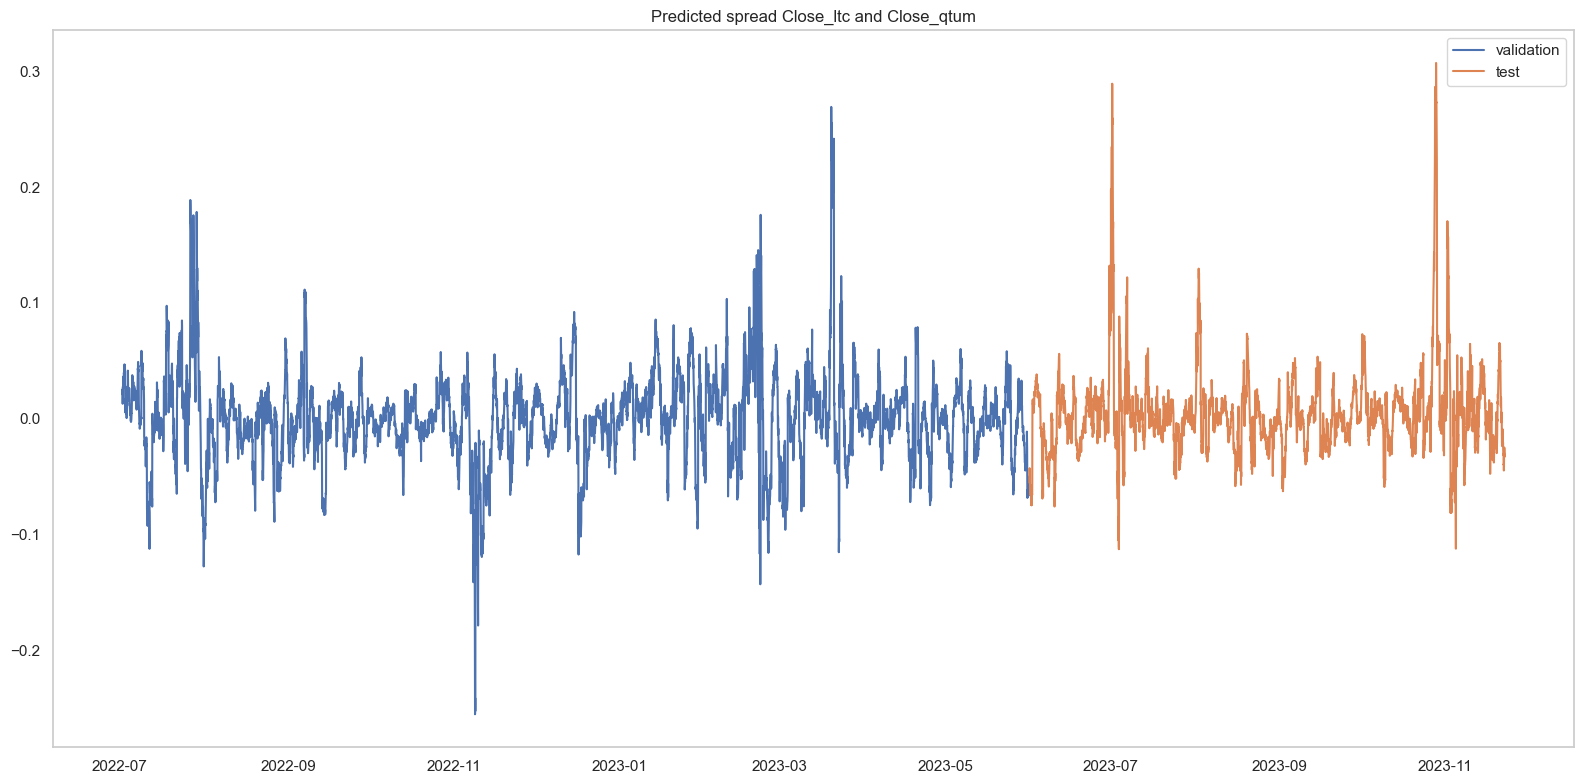

In [253]:
n_rows = 1
n_cols = 1

plt.figure(figsize=(16, 8))

for i, pair in enumerate(pairs):
    plt.subplot(n_rows, n_cols, i+1)

    plt.plot(validation[f'spread_{pair[0]}_and_{pair[1]}'], label='validation')
    plt.plot(test[f'spread_{pair[0]}_and_{pair[1]}'], label='test')
    plt.legend()
    plt.grid()
    plt.title(f'Predicted spread {pair[0]} and {pair[1]}')

plt.tight_layout()
plt.show()

## Strategy

Conditions for opening a position:
- $spread_{t} \geq threshold_{open}$: buy the main instrument in the amount of $amt$ and sell the second instrument in the amount of $amt * w$
- $spread_{t} \leq -1 * threshold_{open}$: sell the main instrument in the amount of $amt$ and buy the second instrument in the amount of $amt * w$
Conditions for closing a position:
- $spread_{t} \leq threshold_{close}, pos > 0$: sell the main instrument in the amount of $amt$ and buy the second instrument in the amount of $amt * w$
- $spread_{t} \geq -1 * threshold_{close}, pos < 0$: buy the main instrument in the amount of $amt$ and sell the second instrument in the amount of $amt * w$

In [254]:
def pair_strategy(curr_trade: list, pos: float, index: int, spread: pd.Series, data: pd.DataFrame, t_cols: list) -> tuple:
    if spread >= data[t_cols[0]][index] and pos == 0:  # open long
        pos = amount
        desicion = 'open'
    elif spread <= -data[t_cols[0]][index] and pos == 0:  # open short
        pos = -amount
        desicion = 'open'
    elif (spread <= data[t_cols[1]][index] and pos > 0) or (spread >= -data[t_cols[1]][index] and pos < 0):  # close
        pos = 0
        desicion = 'close'
    else:
        desicion = 'hold'
    return desicion, pos

In [255]:
def plot_results(info: pd.DataFrame, price_cols: str, t_cols: list) -> None:    
    num_plots = 4

    plt.figure(figsize=(20, 14))
    
    plt.subplot(num_plots, 1, 1)
    plt.plot(info[price_cols[0]], label=price_cols[0])
    plt.legend(loc='upper left')
    plt.twinx()
    plt.plot(info[price_cols[1]], label=price_cols[1], color='C1')
    plt.legend(loc='upper right')
    plt.grid()
    plt.title(f'Prices of {price_cols[0]} and {price_cols[1]}')

    plt.subplot(num_plots, 1, 2)
    plt.plot(info.index, info['real_pnl'])
    plt.grid()
    plt.title(f'Pnl {price_cols[0]} and {price_cols[1]}')
    
    plt.subplot(num_plots, 1, 3)
    plt.plot(info.index, info['position'])
    plt.grid()
    plt.title('Position')

    plt.subplot(num_plots, 1, 4)
    plt.plot(info.index, info['spread'])
    plt.scatter(info[info['trades'] == 'open'].index, info[info['trades'] == 'open']['spread'], color='green', label='open pos')
    plt.scatter(info[info['trades'] == 'close'].index, info[info['trades'] == 'close']['spread'], color='red', label='close pos')
    if len(t_cols) == 2:
        plt.plot(info.index, info[t_cols[0]], color='green', alpha=0.5, label=t_cols[0])
        plt.plot(info.index, -1 * info[t_cols[0]], color='green', alpha=0.5)
        plt.plot(info.index, info[t_cols[1]], color='red', alpha=0.5, label=t_cols[1])
        plt.plot(info.index, -1 * info[t_cols[1]], color='red', alpha=0.5)
    else:
        colors = ['green', 'green', 'red']
        for index, col in enumerate(t_cols):
            plt.plot(info.index, info[col], color=colors[index], alpha=0.5, label=col)

    plt.grid()
    plt.legend()
    plt.title(f'Spread of {price_cols[0]} and {price_cols[1]}')

    plt.show()

In [256]:
def calc_pnl(last_amount, curr_amount, pos):
    if pos > 0:
        pnl = np.sum(curr_amount - last_amount)
    elif pos < 0:
        pnl = np.sum(last_amount - curr_amount)
    else:
        pnl = 0
    return pnl

# Пока оставлю, но в будущем удалю
def calc_sharpe(pnl: pd.Series) -> float:
    # посчитаем шарп как дельту пнлей, а не через доходности, так как у нас нет формируемого портфеля активов
    
    returns = pnl.diff().fillna(value=0)
    mean_return = returns.mean()
    std = returns.std()
    sharpe = (mean_return) / std * np.sqrt(365 * 25)
    return sharpe

# В будущем удалю
def calc_max_drawdown(pnl: pd.Series) -> float:
    max_pnl = 0
    index_max_pnl = 0
    max_drawdown = 0
    start_index = 0
    end_index = 0
    for index, value in enumerate(pnl.values):
        if value > max_pnl:
            max_pnl = value
            index_max_pnl = index
        else:
            curr_drawdown = max_pnl - value
            if curr_drawdown > max_drawdown:
                max_drawdown = curr_drawdown
                start_index = index_max_pnl
                end_index = index

    return max_drawdown

In [257]:
def run_pair_strategy(df: pd.DataFrame, price_cols: list, spread_col: str, amount: float, w, strategy: 'function', t_cols: list = None, verbose: bool = True, viz: bool = True) -> tuple:
    if t_cols is None:
        t_cols = ['open_t', 'close_t']
    spread_values = df[spread_col].to_numpy()
    amounts_vector = np.array([amount, -w * amount])
    prices = df[price_cols].to_numpy()
    prices_to_order = prices * amounts_vector  # цены для покупки / продажи, учитывая сторону сделки
    
    pnls = []
    open_pnls = []
    trades = []
    all_pos = []
    last_trade = None
    pos = 0

    for index, spread in enumerate(spread_values):
        curr_trade = prices_to_order[index]
        curr_opnl = 0
        curr_pnl = 0
        
        desicion, new_pos = strategy(curr_trade, pos, index, spread, df, t_cols)

        # считаем либо close pnl, либо open pnl
        if desicion == 'open':
            last_trade = curr_trade
            pos = new_pos
        elif desicion == 'close':
            curr_pnl = calc_pnl(last_trade, curr_trade, pos)
            last_trade = None
            pos = 0
        else:
            curr_opnl = calc_pnl(last_trade, curr_trade, pos)
        
        open_pnls.append(curr_opnl)
        pnls.append(curr_pnl)
        trades.append(desicion)
        all_pos.append(pos)
        

    pnls = np.array(pnls)
    open_pnls = np.array(open_pnls)
    trades = np.array(trades)
    
    total_df = df[price_cols].copy()
    total_df['pnl'] = pnls
    total_df['open_pnl'] = open_pnls
    total_df['trades'] = trades
    total_df['position'] = all_pos
    total_df['spread'] = df[spread_col]
    total_df['real_pnl'] = np.cumsum(pnls) + open_pnls
    total_df[t_cols] = df[t_cols]
    
    
    if verbose:
        final_pnl = total_df['real_pnl'].iloc[-1]
        pnl_per_day = final_pnl / (total_df.index[-1] - total_df.index[0]).days
        trades = (total_df['trades'] != 'hold').sum() // 2  # считаем одним трейдом пару открытие-закрытие позиции
        sharpe_ratio = calc_sharpe(total_df['real_pnl'])
        max_dd = calc_max_drawdown(total_df['real_pnl'])
        pnl_to_max_dd = final_pnl / max_dd
        summary = {f'final_pnl {pair}': final_pnl, 'pnl_per_day': pnl_per_day, 'trades': trades, 'max_dd': max_dd, 
                   'sharpe_ratio': sharpe_ratio, 'pnl_to_max_dd': pnl_to_max_dd}
        print(*[f'{key}: {round(value, 4)}' for key, value in summary.items()], sep='\n')
    
    if viz:
        plot_results(total_df, price_cols, t_cols)
        
    return total_df

In [258]:
def startegy_metrics(total_df, data):
    final_pnl = total_df['real_pnl'].iloc[-1]
    final_pnl_test = data['real_pnl'].iloc[-1]

    trades = (total_df['trades'] != 'hold').sum() // 2  # считаем одним трейдом пару открытие-закрытие позиции
    trades_test = (data['trades'] != 'hold').sum() // 2  # считаем одним трейдом пару открытие-закрытие позиции

    sharpe_ratio = calc_sharpe(total_df['real_pnl'])
    sharpe_ratio_test = calc_sharpe(data['real_pnl'])

    max_dd = calc_max_drawdown(total_df['real_pnl'])
    max_dd_test = calc_max_drawdown(data['real_pnl'])

    pnl_to_max_dd = final_pnl / max_dd
    pnl_to_max_dd_test = final_pnl_test / max_dd_test

    summary = {f'final_pnl {pair}': str(round(final_pnl, 4)) + ' ' + str(round(final_pnl_test, 4)), 
                'trades': str(trades) + ' ' + str(trades_test), 
                'max_dd': str(round(max_dd, 4)) + ' ' + str(round(max_dd_test, 4)), 
                'sharpe_ratio': str(round(sharpe_ratio, 4)) + ' ' + str(round(sharpe_ratio_test, 4)), 
                'pnl_to_max_dd': str(round(pnl_to_max_dd, 4)) + ' ' + str(round(pnl_to_max_dd_test, 4))}
    print(*[f'{key}: {value}' for key, value in summary.items()], sep='\n')
    print("\n")

## Test strategy

Validation

final_pnl ('Close_ltc', 'Close_qtum'): 15.251
pnl_per_day: 0.0455
trades: 180
max_dd: 43.112
sharpe_ratio: 0.3781
pnl_to_max_dd: 0.3538


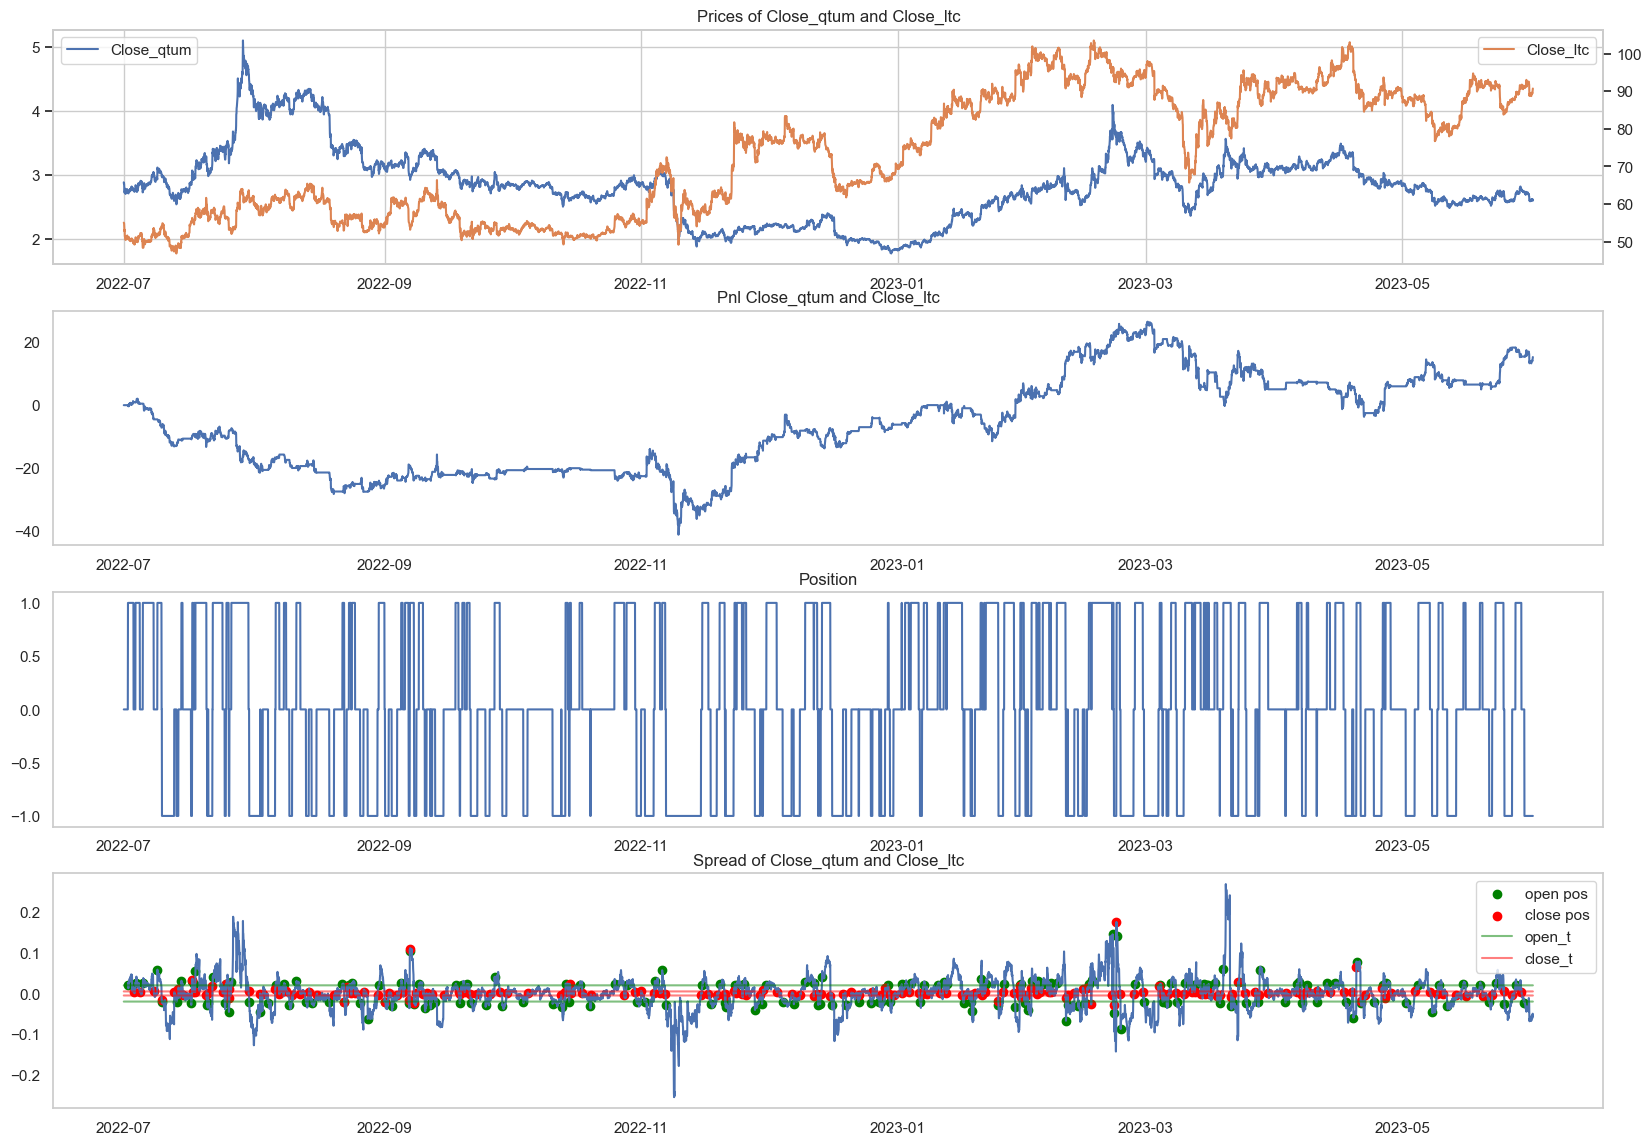

In [259]:
amount = 1
w = 1
open_t = 0.02
close_t = 0.005

validation['open_t'] = open_t
validation['close_t'] = close_t

total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy, verbose=True, viz=True)
    total_dfs.append(total_df)

Test

final_pnl ('Close_ltc', 'Close_qtum'): -10.864
pnl_per_day: -0.0621
trades: 104
max_dd: 37.961
sharpe_ratio: -0.5318
pnl_to_max_dd: -0.2862


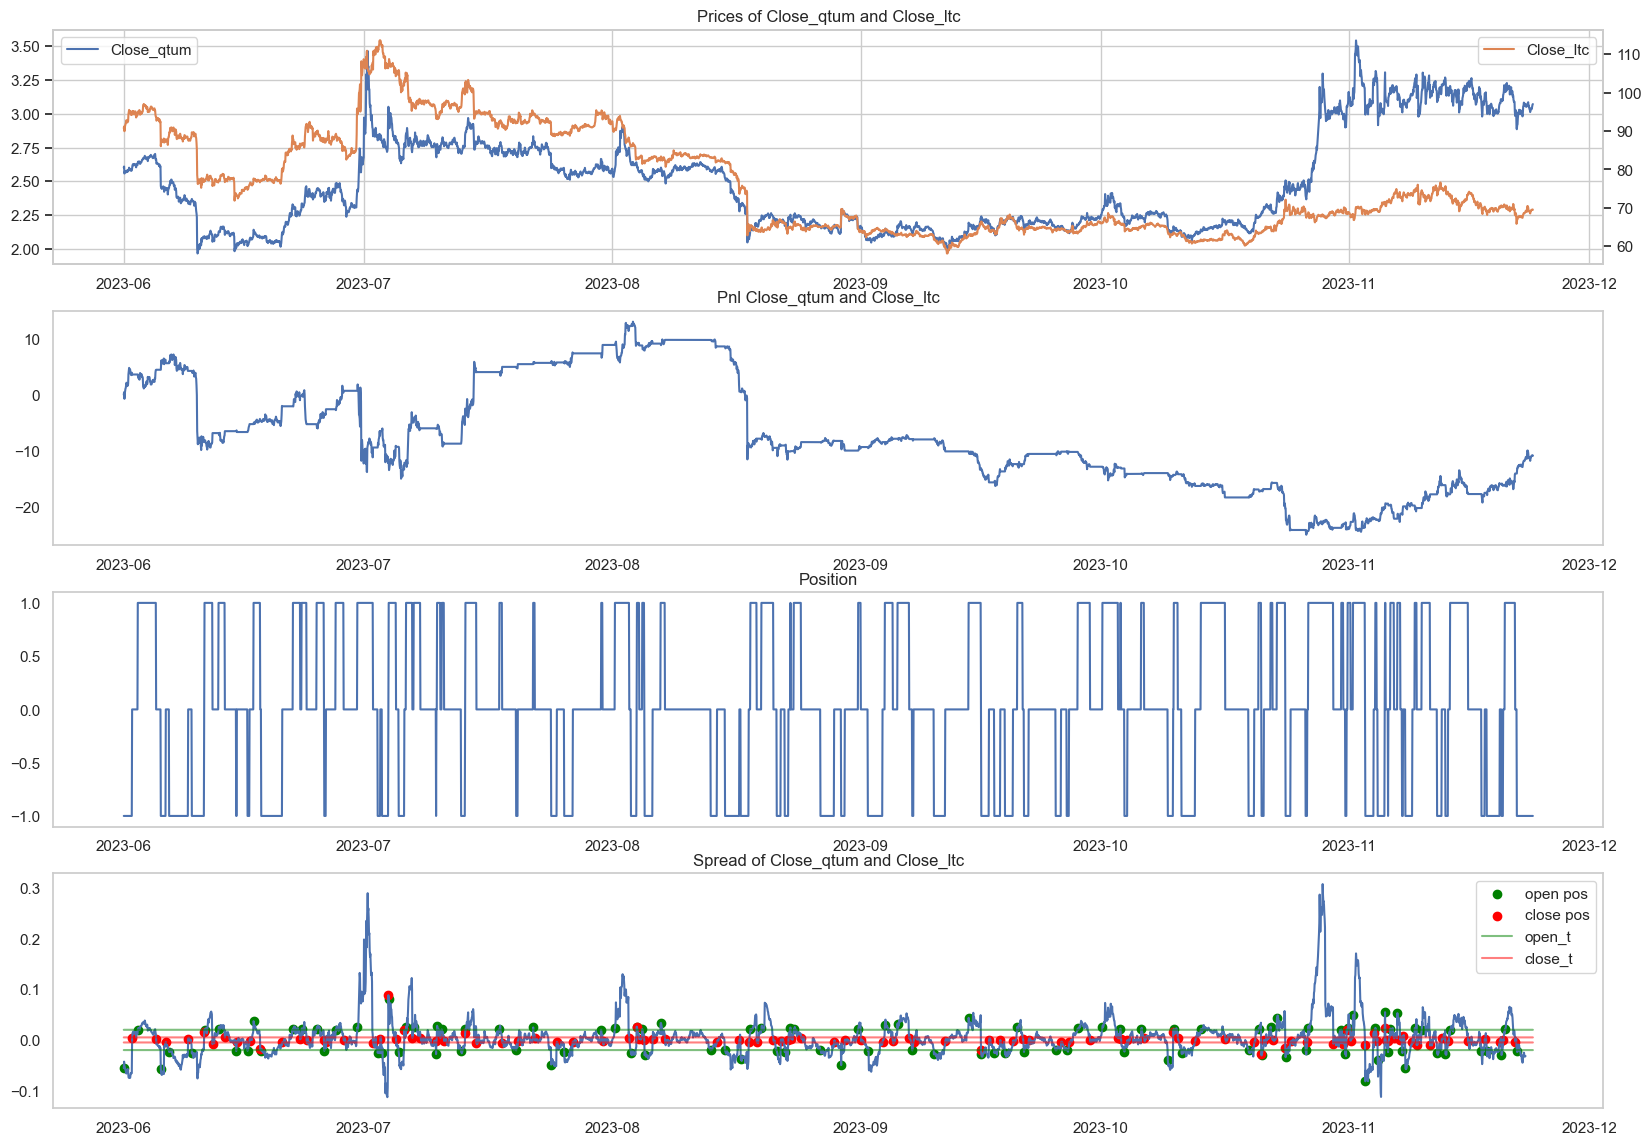

In [260]:
amount = 1
w = 1
open_t = 0.02
close_t = 0.005

test['open_t'] = open_t
test['close_t'] = close_t

total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy, verbose=True, viz=True)
    total_dfs.append(total_df)

### Improvements

We will not trade at moments when p-value < p_value_threshold

In [261]:
def correct_threshold(open_t: float, close_t: float, fit_results: list, p_value_threshold: float) -> list:
    open_t_corrected = open_t.copy()
    close_t_corrected = close_t.copy()
    for index, dates in enumerate(fit_results['dates']):
        p_value = fit_results['p_values'][index]
        start = dates[1]
        end = dates[2]
        if p_value > p_value_threshold:
            # open_t_corrected.iloc[start:end] = 0.2
            # close_t_corrected.iloc[start:end] = -0.2
            open_t_corrected.iloc[start:end] = 0.02
            close_t_corrected.iloc[start:end] = -0.02
    return open_t_corrected, close_t_corrected

Validation

final_pnl ('Close_ltc', 'Close_qtum'): 14.383
pnl_per_day: 0.0429
trades: 171
max_dd: 43.58
sharpe_ratio: 0.3415
pnl_to_max_dd: 0.33


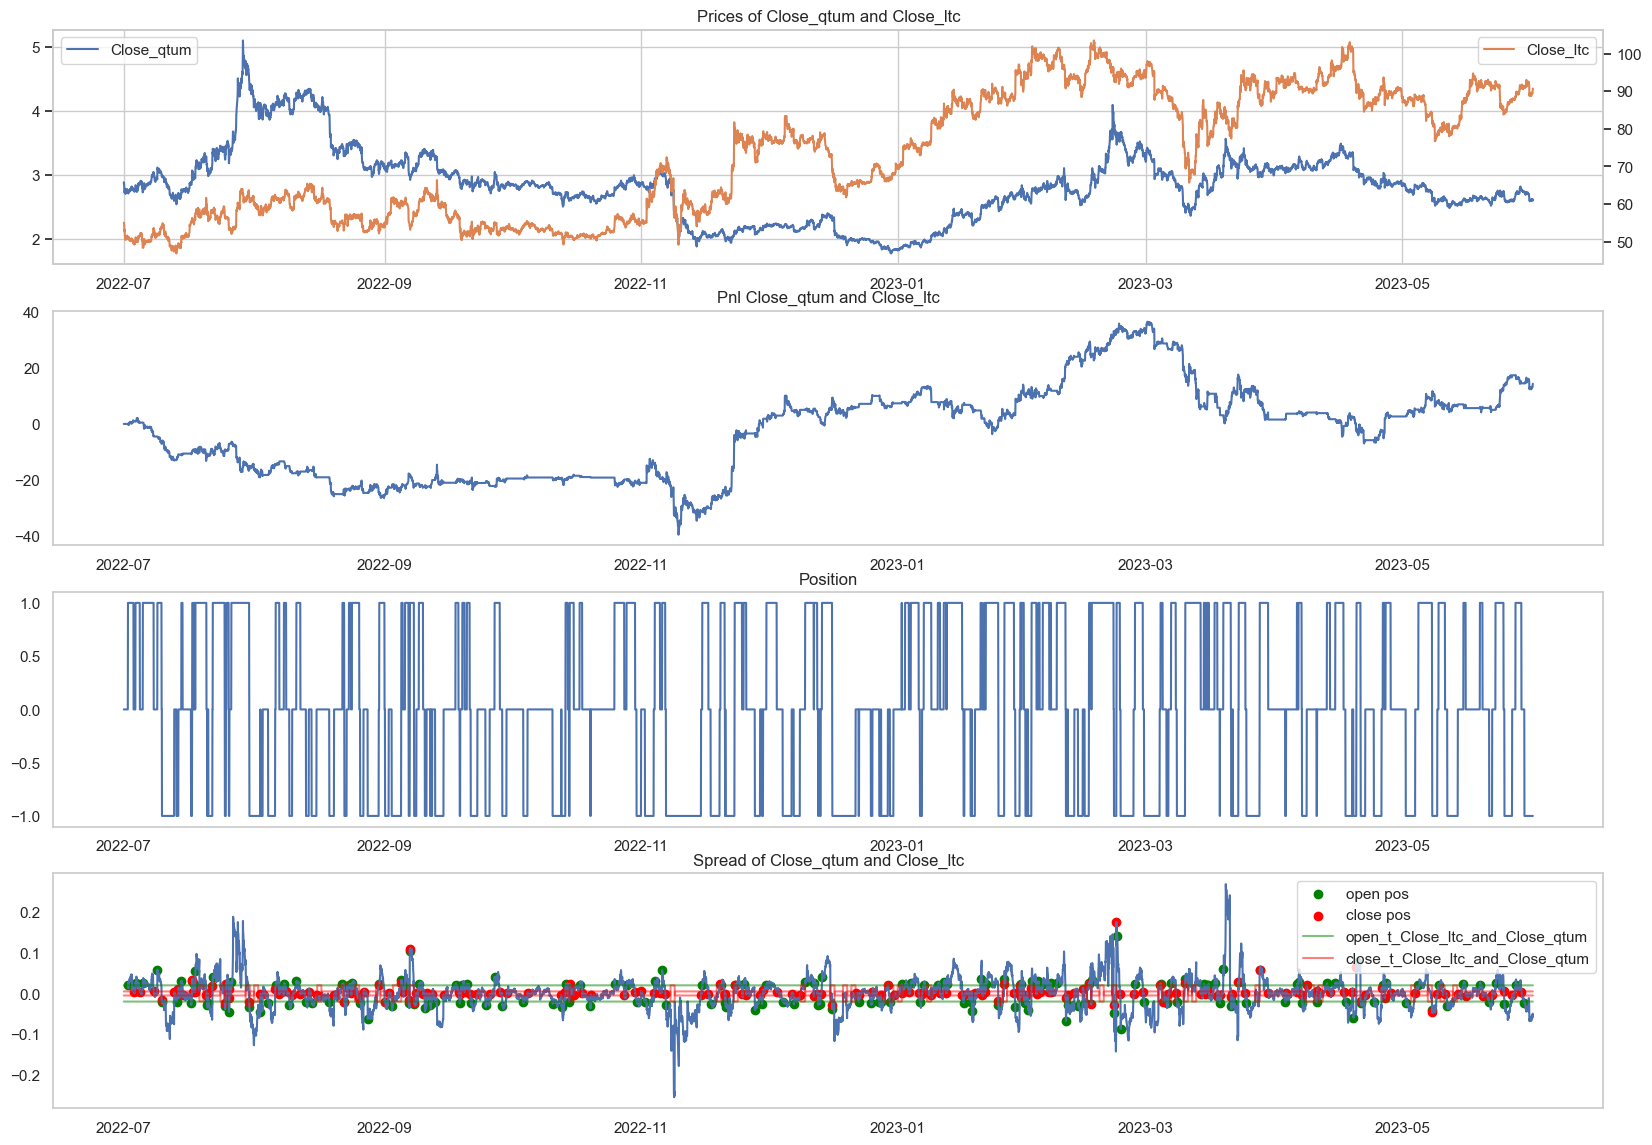

In [262]:
amount = 1
w = 1
open_t = 0.02
close_t = 0.005

p_value_threshold = 0.5

validation['open_t'] = open_t
validation['close_t'] = close_t

for pair, fit_result in zip(pairs, fit_results):
    open_t_corrected, close_t_corrected = correct_threshold(validation['open_t'], validation['close_t'], fit_result, p_value_threshold)
    validation[f'open_t_{pair[0]}_and_{pair[1]}'] = open_t_corrected
    validation[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t_corrected

# total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy, 
                                [f'open_t_{pair[0]}_and_{pair[1]}', f'close_t_{pair[0]}_and_{pair[1]}'], verbose=True, viz=True)
    # total_dfs.append(total_df)

Test

final_pnl ('Close_ltc', 'Close_qtum'): -6.938
pnl_per_day: -0.0396
trades: 103
max_dd: 34.416
sharpe_ratio: -0.3283
pnl_to_max_dd: -0.2016


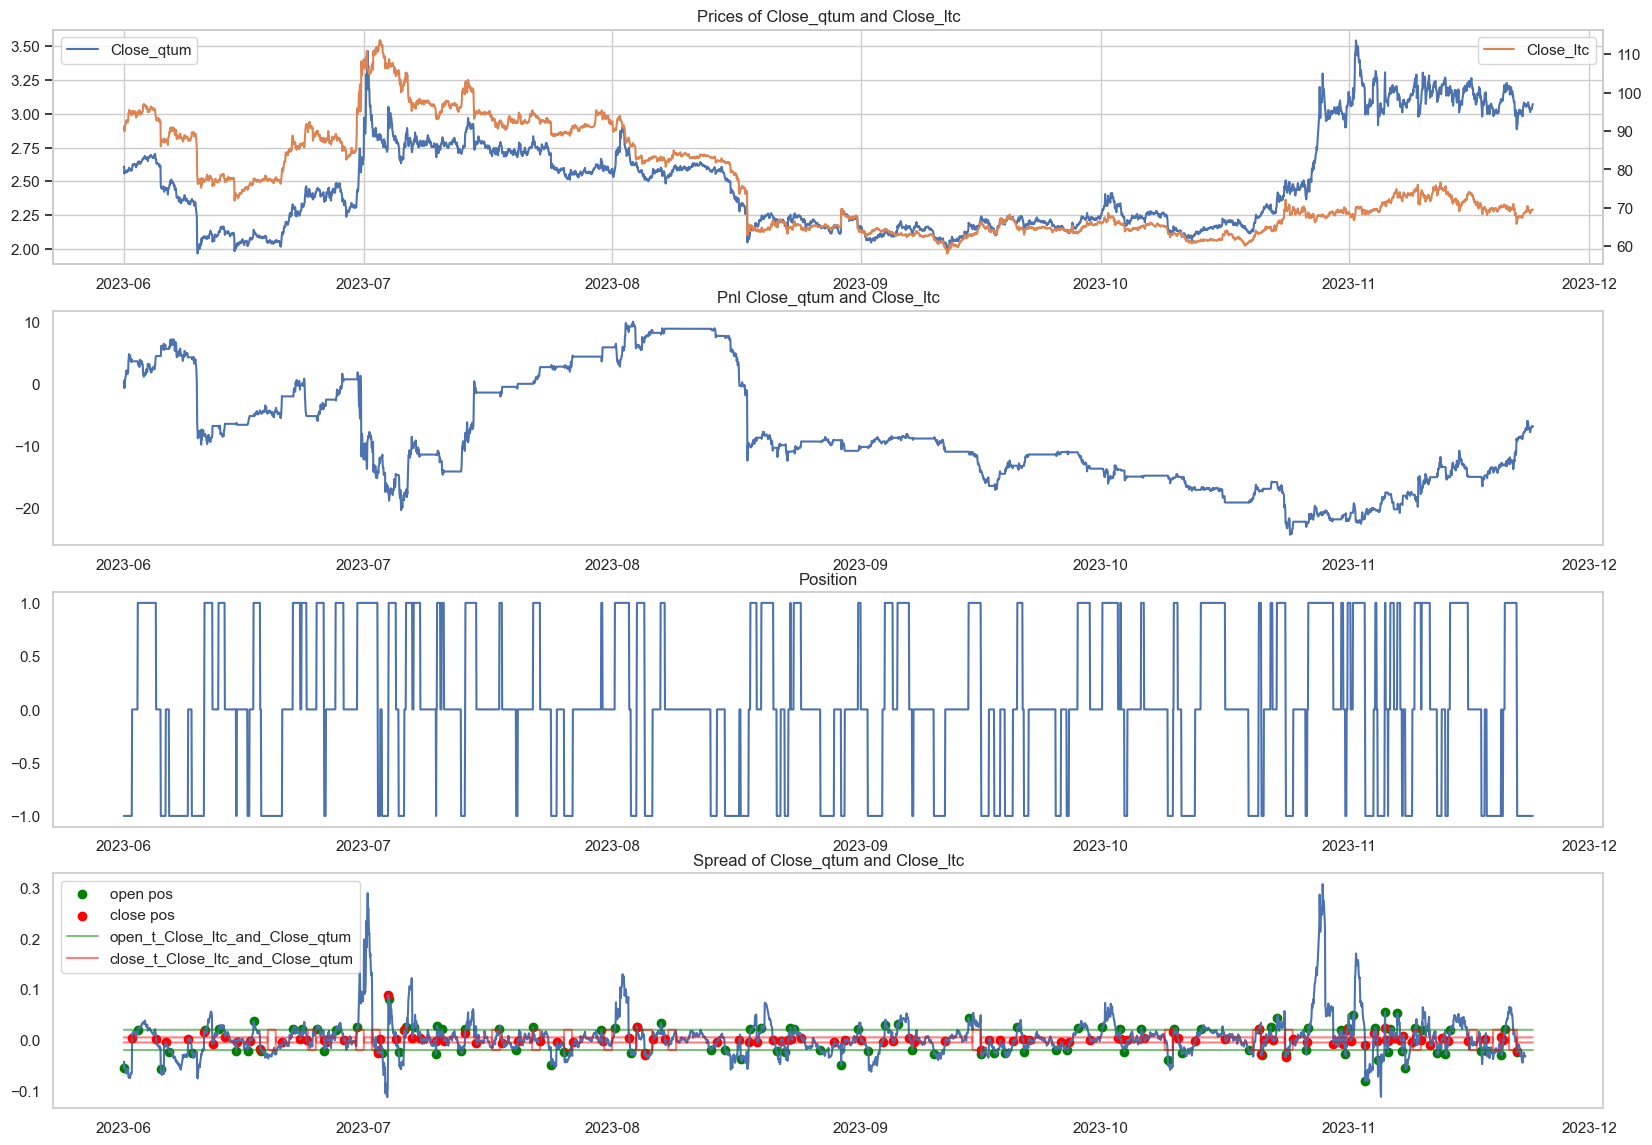

In [263]:
amount = 1
w = 1
open_t = 0.02
close_t = 0.005

p_value_threshold = 0.5

test['open_t'] = open_t
test['close_t'] = close_t

for pair, fit_result in zip(pairs, fit_results):
    open_t_corrected, close_t_corrected = correct_threshold(test['open_t'], test['close_t'], fit_result, p_value_threshold)
    test[f'open_t_{pair[0]}_and_{pair[1]}'] = open_t_corrected
    test[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t_corrected

# total_dfs = []
for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy, 
                                [f'open_t_{pair[0]}_and_{pair[1]}', f'close_t_{pair[0]}_and_{pair[1]}'], verbose=True, viz=True)
    # total_dfs.append(total_df)

### Another improvement

As boundaries, take the average value of the spread on the moving window + some constant.

We get the following:

$threshold_{open}(t) = spread(t, t-w) + k_{open}$

$threshold_{close}(t) = spread(t, t-w) + k_{close}$

$k_{close} < k_{open}$

Where:

$threshold_{open}(t)$ - limit for opening a position

$threshold_{close}(t)$ - limit for closing a position

$spread(t, t-w)$ - average spread value in the period from moment $t - w$ to moment $t$

$w$ - sliding window size

final_pnl ('Close_ltc', 'Close_qtum'): 23.101
pnl_per_day: 0.069
trades: 161
max_dd: 45.734
sharpe_ratio: 0.5239
pnl_to_max_dd: 0.5051


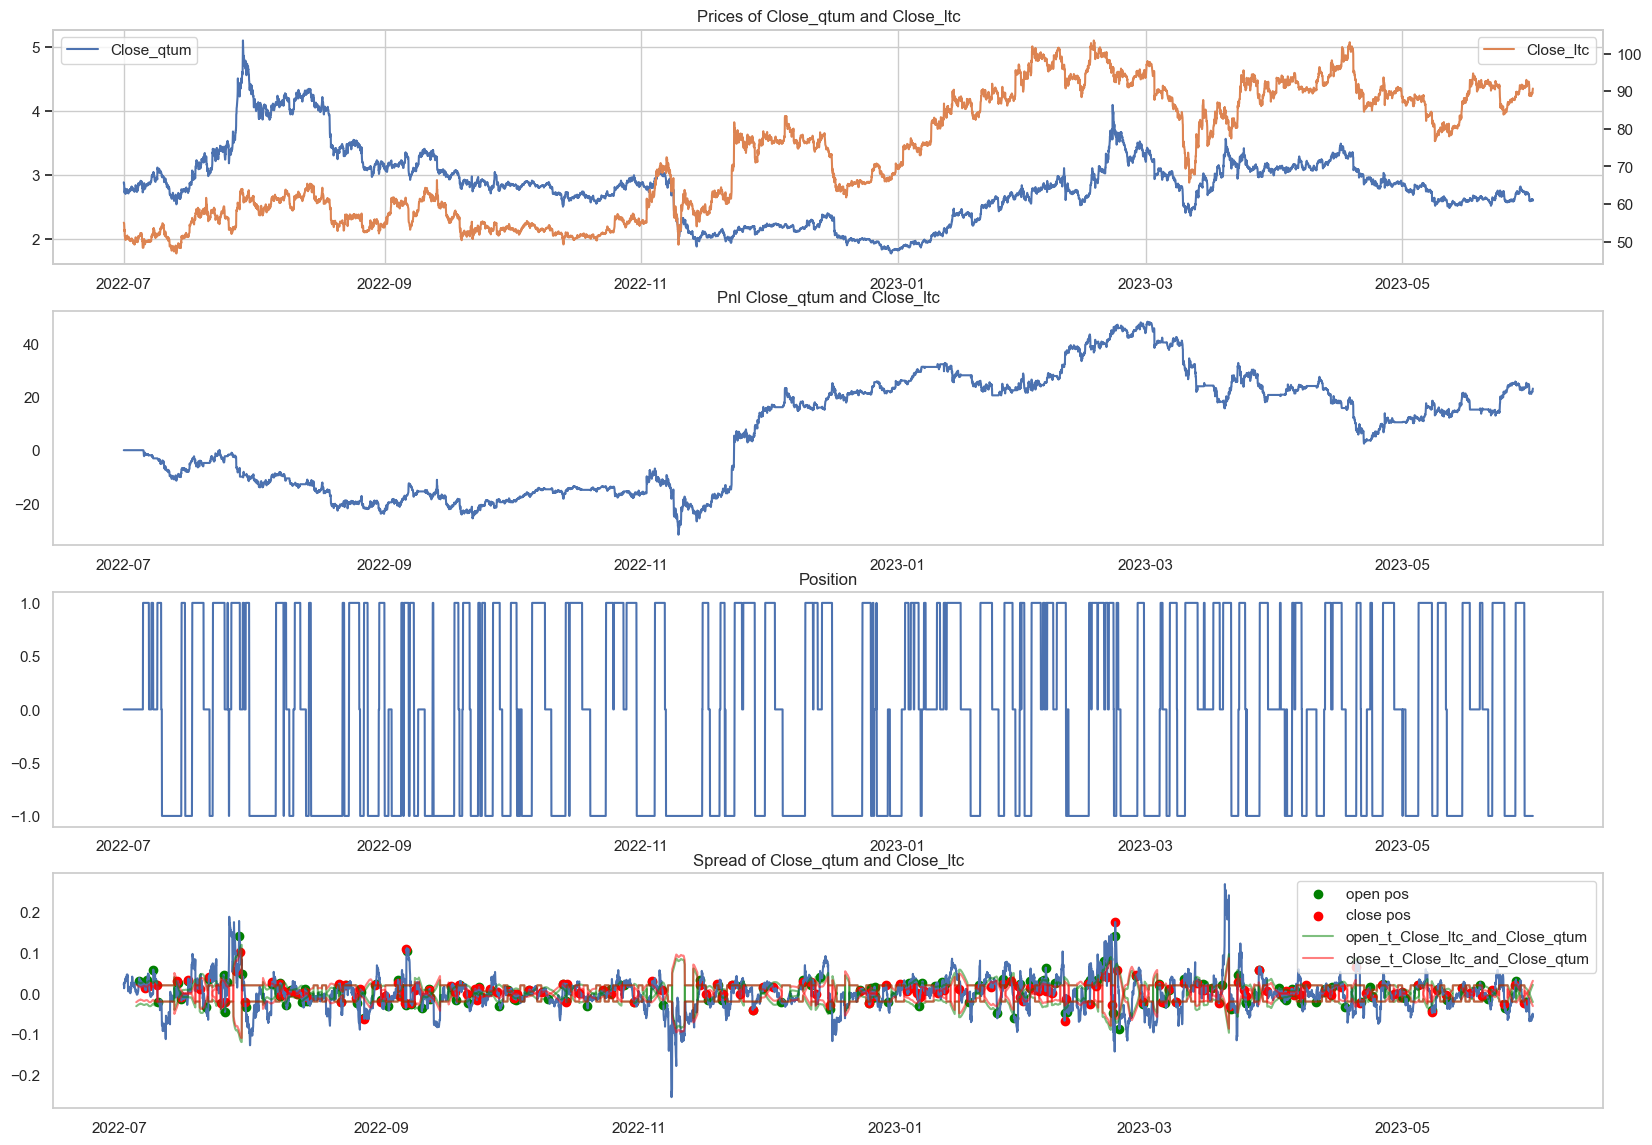

In [264]:
# amount = 1
# weight = 0.02
amount = 1
w = 1

p_value_threshold = 0.2

window = 24 * 3
k_open = 0.01
k_close = 0

for pair, fit_result in zip(pairs, fit_results):
    rolling_spread = validation[f'spread_{pair[0]}_and_{pair[1]}'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    validation[f'open_t_{pair[0]}_and_{pair[1]}'] = open_t
    validation[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t

    open_t_corrected, close_t_corrected = correct_threshold(validation[f'open_t_{pair[0]}_and_{pair[1]}'], 
                                                            validation[f'close_t_{pair[0]}_and_{pair[1]}'], 
                                                            fit_result, p_value_threshold)
    
    validation[f'open_t_{pair[0]}_and_{pair[1]}'] = open_t_corrected
    validation[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t_corrected

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy, 
                                [f'open_t_{pair[0]}_and_{pair[1]}', f'close_t_{pair[0]}_and_{pair[1]}'], verbose=True, viz=True)

Test

final_pnl ('Close_ltc', 'Close_qtum'): 6.489
pnl_per_day: 0.0371
trades: 99
max_dd: 37.126
sharpe_ratio: 0.2868
pnl_to_max_dd: 0.1748


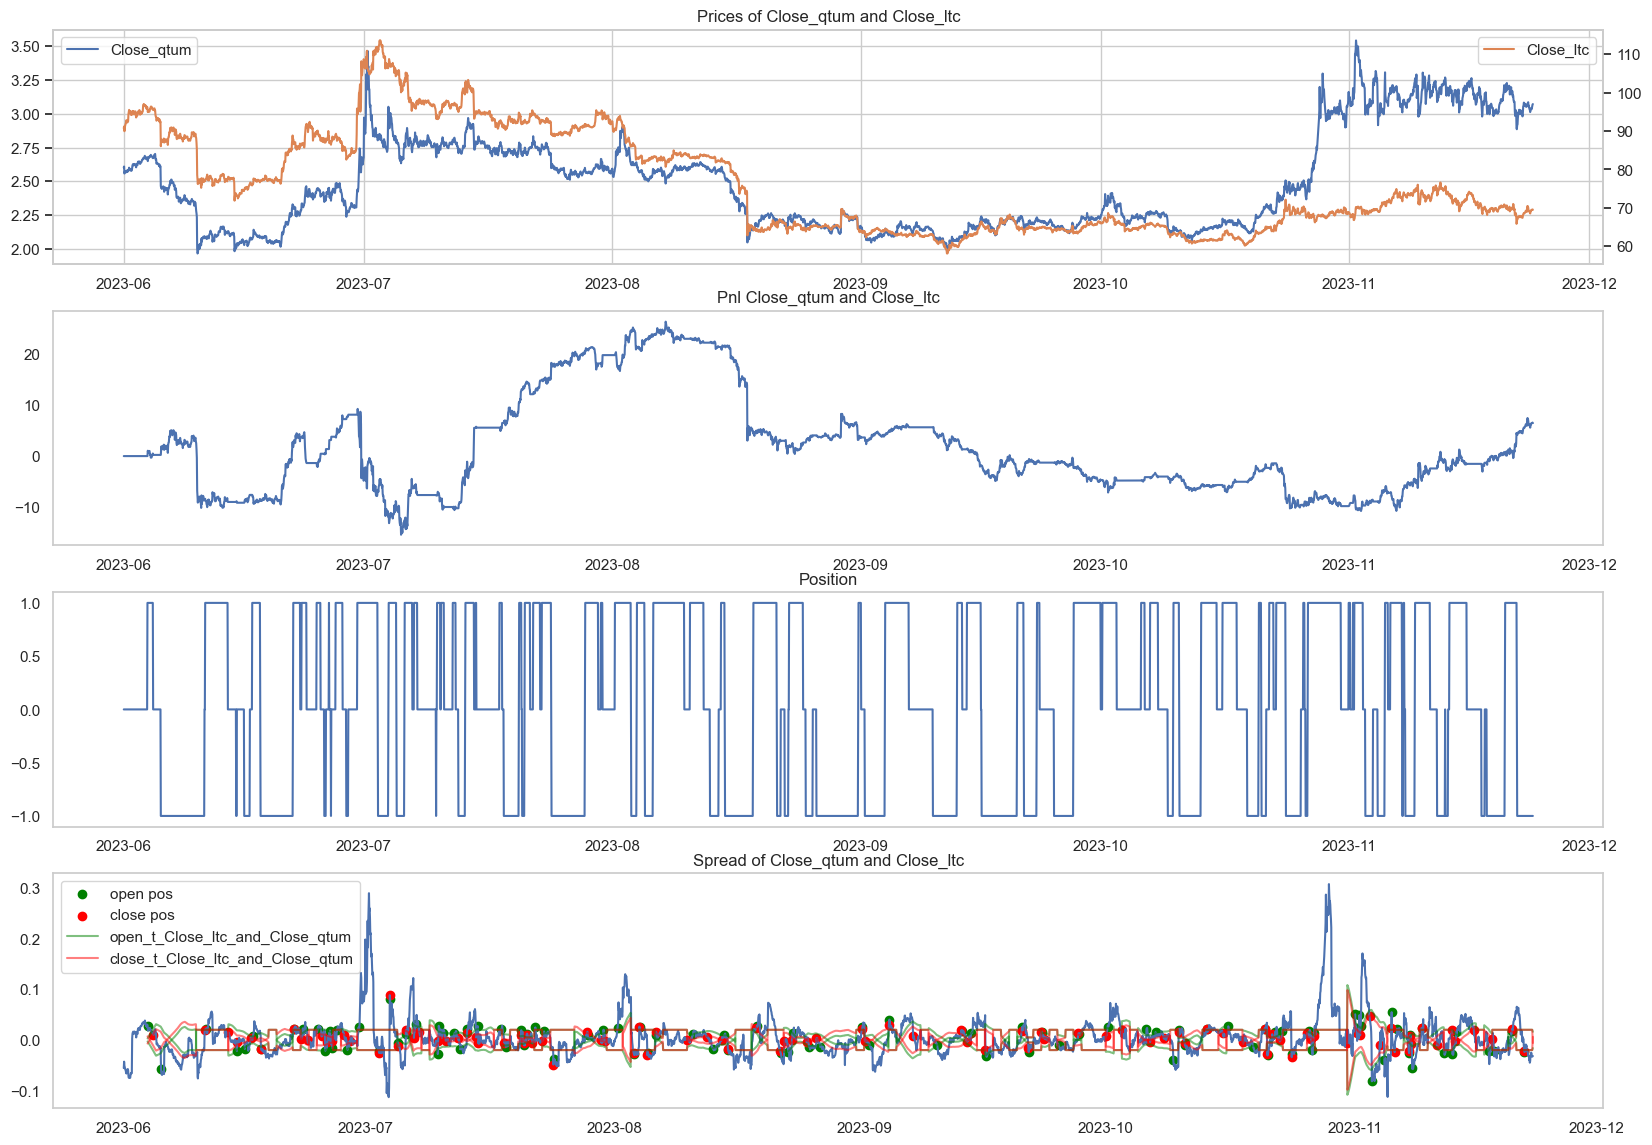

In [265]:
# amount = 1
# weight = 0.02
amount = 1
w = 1

p_value_threshold = 0.2

window = 24 * 3
k_open = 0.01
k_close = 0

for pair, fit_result in zip(pairs, fit_results):
    rolling_spread = test[f'spread_{pair[0]}_and_{pair[1]}'].rolling(window=window)

    open_t = rolling_spread.mean() + k_open
    close_t = rolling_spread.mean() + k_close

    test[f'open_t_{pair[0]}_and_{pair[1]}'] = open_t
    test[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t

    open_t_corrected, close_t_corrected = correct_threshold(test[f'open_t_{pair[0]}_and_{pair[1]}'], 
                                                            test[f'close_t_{pair[0]}_and_{pair[1]}'], 
                                                            fit_result, p_value_threshold)
    
    test[f'open_t_{pair[0]}_and_{pair[1]}'] = open_t_corrected
    test[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t_corrected

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy, 
                                [f'open_t_{pair[0]}_and_{pair[1]}', f'close_t_{pair[0]}_and_{pair[1]}'], verbose=True, viz=True)

By making weight lower we get lower drawdown, but pnl and sharpe also became lower on validation

Consider another strategy
$threshold_{long}(t) = spread(t, t-w) + k_{open}$  
$threshold_{short}(t) = spread(t, t-w) - k_{open}$  

In [266]:
def pair_strategy_2(curr_trade: list, pos: float, index: int, spread: pd.Series, data: pd.DataFrame, t_cols: list) -> tuple:
    if spread >= data[t_cols[0]][index] and pos == 0:  # open long
        pos = amount
        desicion = 'open'
    elif spread <= data[t_cols[1]][index] and pos == 0:  # open short
        pos = -amount
        desicion = 'open'
    elif (spread <= data[t_cols[2]][index] and pos > 0) or (spread >= -data[t_cols[2]][index] and pos < 0):  # close
        pos = 0
        desicion = 'close'
    else:
        desicion = 'hold'
    return desicion, pos
    

Validation

final_pnl ('Close_ltc', 'Close_qtum'): 9.996
pnl_per_day: 0.0298
trades: 585
max_dd: 6.781
sharpe_ratio: 1.2275
pnl_to_max_dd: 1.4741


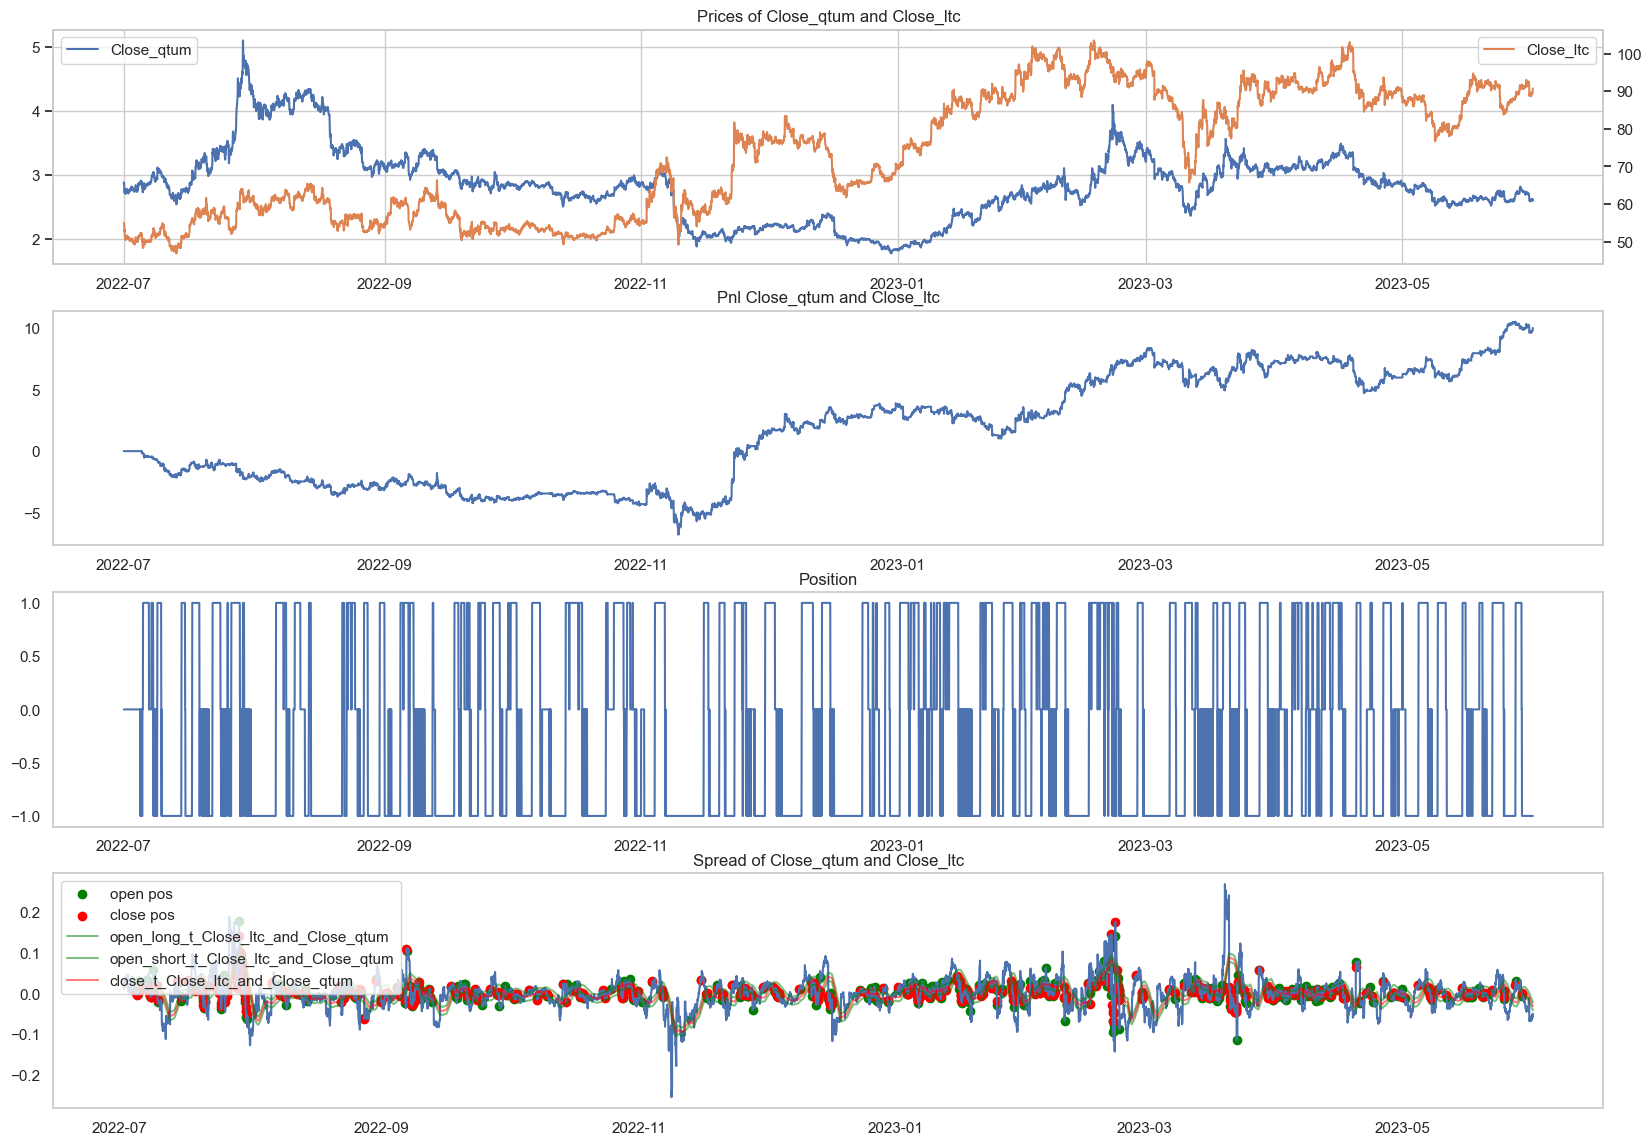

In [267]:
amount = 1
w = 0.2

p_value_threshold = 0.2

window = 24 * 3
k_open = 0.01
k_close = 0

for pair, fit_result in zip(pairs, fit_results):
    rolling_spread = validation[f'spread_{pair[0]}_and_{pair[1]}'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    validation[f'open_long_t_{pair[0]}_and_{pair[1]}'] = open_long_t
    validation[f'open_short_t_{pair[0]}_and_{pair[1]}'] = open_short_t
    validation[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy_2, 
                                [f'open_long_t_{pair[0]}_and_{pair[1]}', f'open_short_t_{pair[0]}_and_{pair[1]}', 
                                f'close_t_{pair[0]}_and_{pair[1]}'], verbose=True, viz=True)

Test

final_pnl ('Close_ltc', 'Close_qtum'): -1.01
pnl_per_day: -0.0058
trades: 397
max_dd: 5.564
sharpe_ratio: -0.244
pnl_to_max_dd: -0.1815


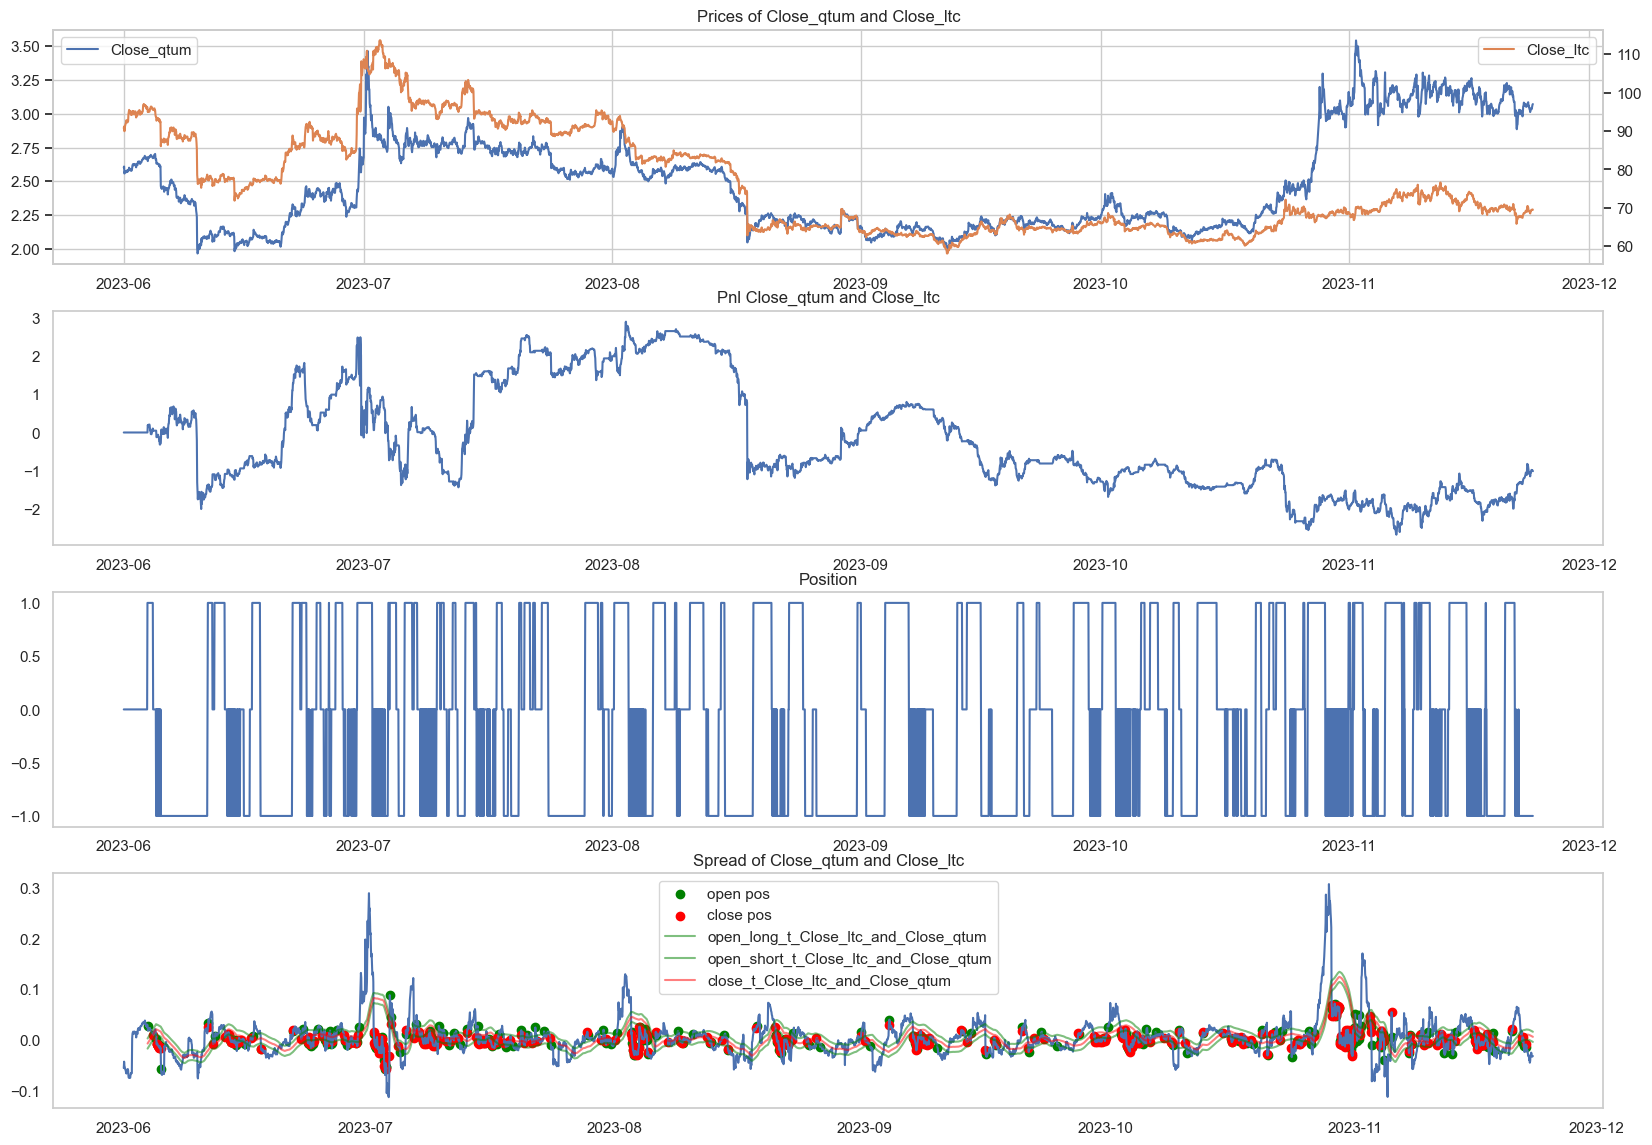

In [268]:
amount = 1
w = 0.2

p_value_threshold = 0.2

window = 24 * 3
k_open = 0.01
k_close = 0

for pair, fit_result in zip(pairs, fit_results):
    rolling_spread = test[f'spread_{pair[0]}_and_{pair[1]}'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    test[f'open_long_t_{pair[0]}_and_{pair[1]}'] = open_long_t
    test[f'open_short_t_{pair[0]}_and_{pair[1]}'] = open_short_t
    test[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy_2, 
                                [f'open_long_t_{pair[0]}_and_{pair[1]}', f'open_short_t_{pair[0]}_and_{pair[1]}', 
                                f'close_t_{pair[0]}_and_{pair[1]}'], verbose=True, viz=True)

Consider all of the approaches together

final_pnl ('Close_ltc', 'Close_qtum'): 9.74
pnl_per_day: 0.0291
trades: 390
max_dd: 6.318
sharpe_ratio: 1.1526
pnl_to_max_dd: 1.5416


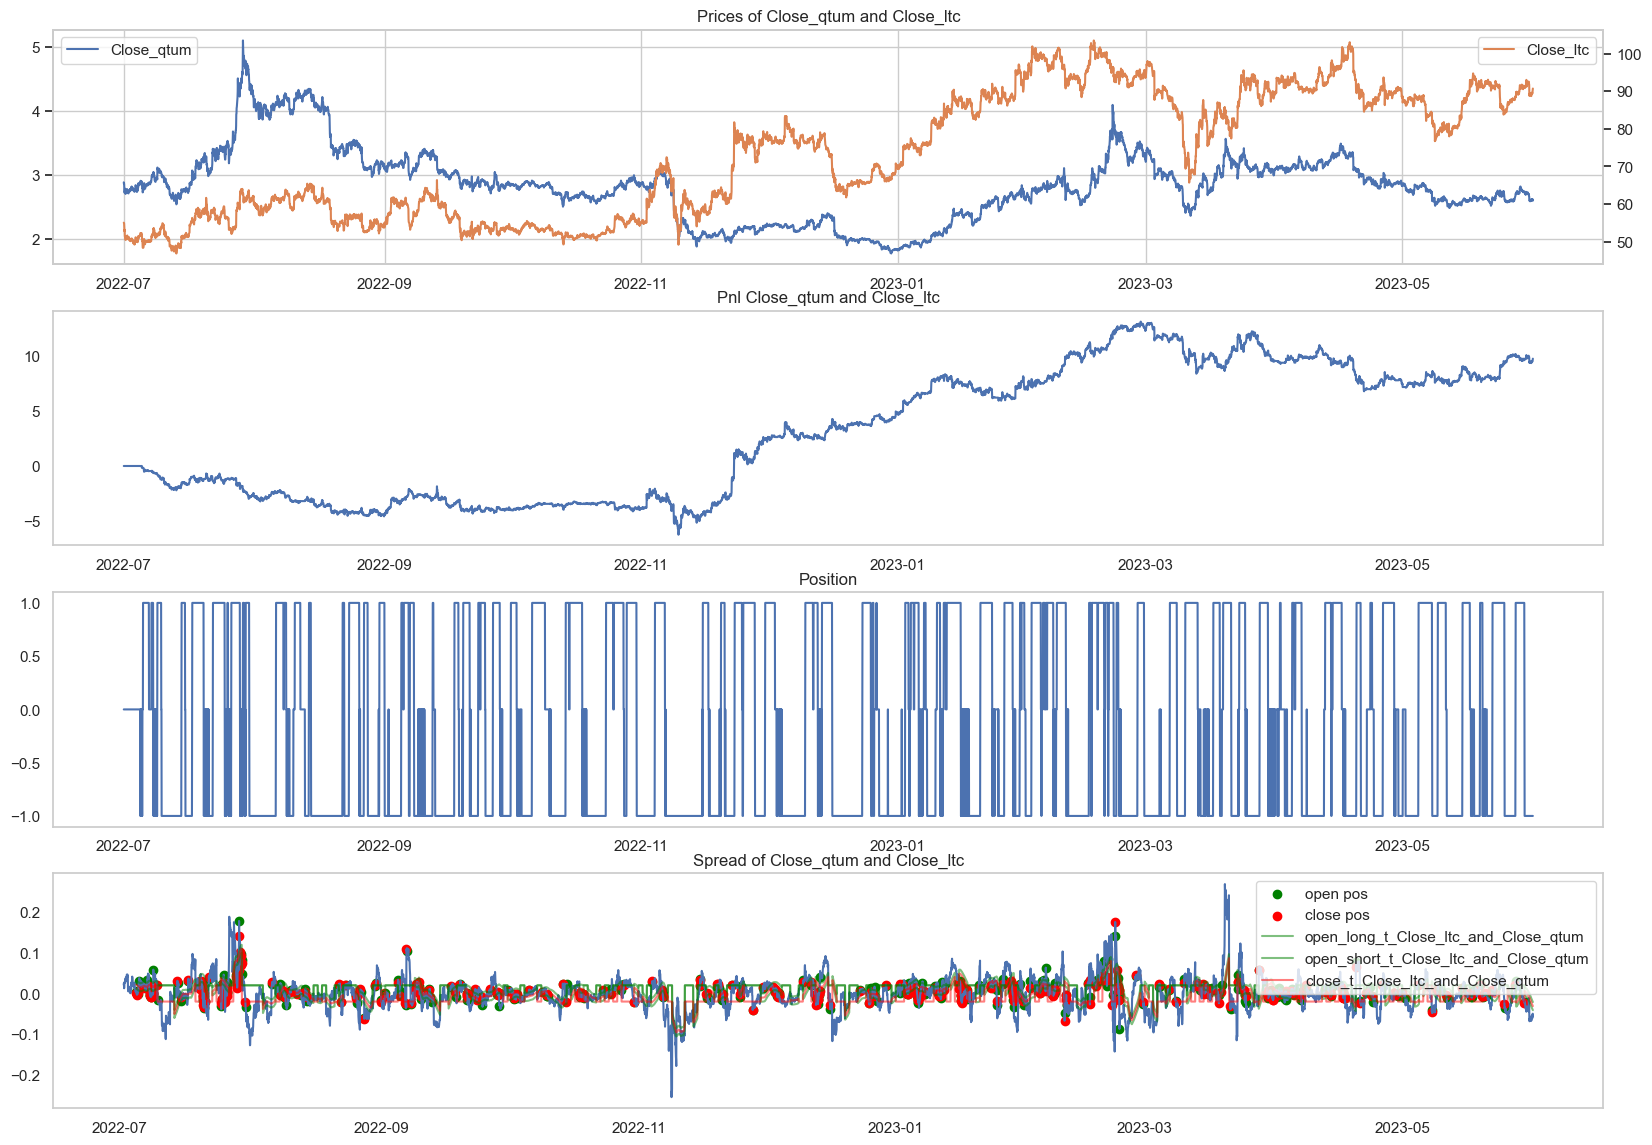

In [269]:
amount = 1
weight = 0.02

p_value_threshold = 0.2

window = 24 * 3
k_open = 0.01
k_close = 0

for pair, fit_result in zip(pairs, fit_results):
    rolling_spread = validation[f'spread_{pair[0]}_and_{pair[1]}'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    validation[f'open_long_t_{pair[0]}_and_{pair[1]}'] = open_long_t
    validation[f'open_short_t_{pair[0]}_and_{pair[1]}'] = open_short_t
    validation[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t

    open_long_t_corrected, close_t_corrected = correct_threshold(validation[f'open_long_t_{pair[0]}_and_{pair[1]}'], validation[f'close_t_{pair[0]}_and_{pair[1]}'], fit_result, p_value_threshold)
    open_short_t_corrected, close_t_corrected = correct_threshold(validation[f'open_short_t_{pair[0]}_and_{pair[1]}'], validation[f'close_t_{pair[0]}_and_{pair[1]}'], fit_result, p_value_threshold)

    validation[f'open_long_t_{pair[0]}_and_{pair[1]}'] = open_long_t_corrected
    validation[f'open_short_t_{pair[0]}_and_{pair[1]}'] = open_short_t_corrected
    validation[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t_corrected

for pair in pairs:
    total_df = run_pair_strategy(validation, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy_2, 
                                [f'open_long_t_{pair[0]}_and_{pair[1]}', f'open_short_t_{pair[0]}_and_{pair[1]}', 
                                f'close_t_{pair[0]}_and_{pair[1]}'], verbose=True, viz=True)

final_pnl ('Close_ltc', 'Close_qtum'): -4.527
pnl_per_day: -0.0259
trades: 240
max_dd: 8.475
sharpe_ratio: -1.0171
pnl_to_max_dd: -0.5342


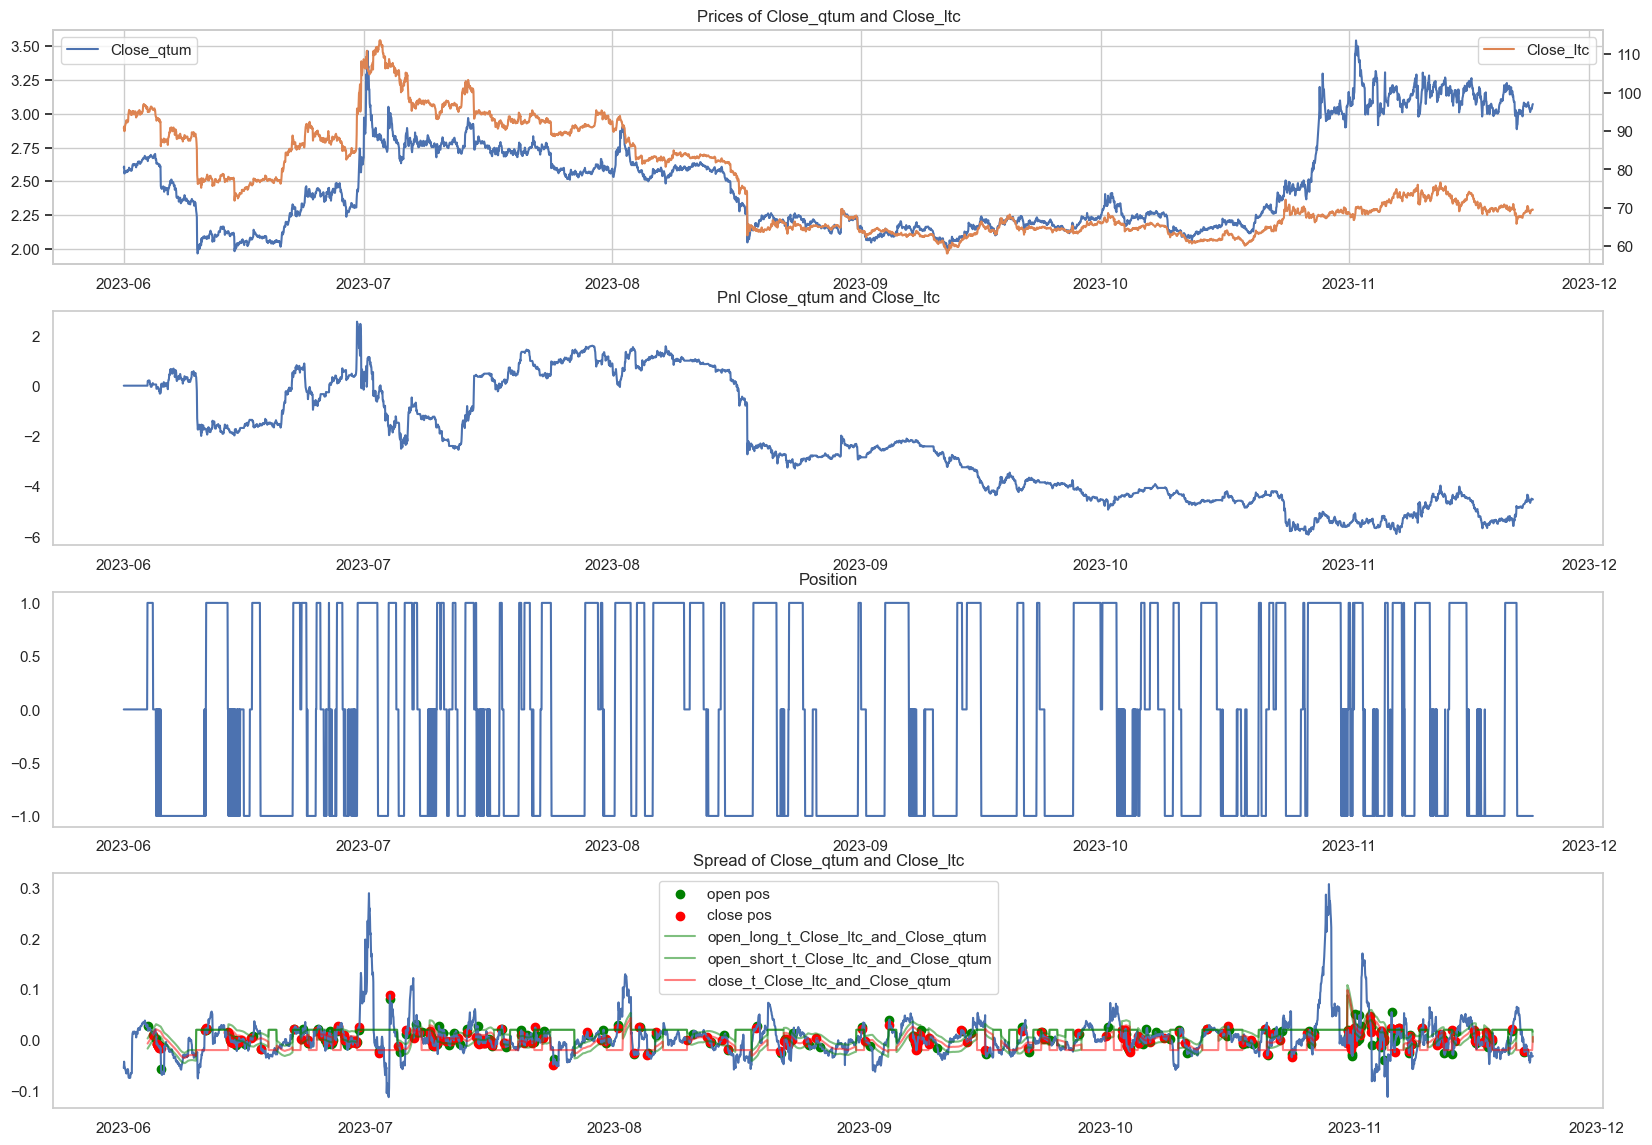

In [270]:
amount = 1
weight = 0.02

p_value_threshold = 0.2

window = 24 * 3
k_open = 0.01
k_close = 0

for pair, fit_result in zip(pairs, fit_results):
    rolling_spread = test[f'spread_{pair[0]}_and_{pair[1]}'].rolling(window=window)

    open_long_t = rolling_spread.mean() + k_open
    open_short_t = rolling_spread.mean() - k_open
    close_t = rolling_spread.mean() + k_close


    test[f'open_long_t_{pair[0]}_and_{pair[1]}'] = open_long_t
    test[f'open_short_t_{pair[0]}_and_{pair[1]}'] = open_short_t
    test[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t

    open_long_t_corrected, close_t_corrected = correct_threshold(test[f'open_long_t_{pair[0]}_and_{pair[1]}'], test[f'close_t_{pair[0]}_and_{pair[1]}'], fit_result, p_value_threshold)
    open_short_t_corrected, close_t_corrected = correct_threshold(test[f'open_short_t_{pair[0]}_and_{pair[1]}'], test[f'close_t_{pair[0]}_and_{pair[1]}'], fit_result, p_value_threshold)

    test[f'open_long_t_{pair[0]}_and_{pair[1]}'] = open_long_t_corrected
    test[f'open_short_t_{pair[0]}_and_{pair[1]}'] = open_short_t_corrected
    test[f'close_t_{pair[0]}_and_{pair[1]}'] = close_t_corrected

for pair in pairs:
    total_df = run_pair_strategy(test, [pair[1], pair[0]], f'spread_{pair[0]}_and_{pair[1]}', amount, w, pair_strategy_2, 
                                [f'open_long_t_{pair[0]}_and_{pair[1]}', f'open_short_t_{pair[0]}_and_{pair[1]}', 
                                f'close_t_{pair[0]}_and_{pair[1]}'], verbose=True, viz=True)